# Music Genre Classification using FMA Dataset and PyTorch CNN

This notebook walks through the process of classifying music genres using the Free Music Archive (FMA) dataset (small subset). We will:
1. Load track metadata.
2. Explore and visualize the genre distribution.
3. Balance the dataset (optional).
4. Extract Mel-Frequency Cepstral Coefficients (MFCCs) as features using `torchaudio`.
5. Define and train a Convolutional Neural Network (CNN) using PyTorch.
6. Evaluate the model's performance.
7. Predict the genre of an example track.

In [1]:
# -*- coding: utf-8 -*-
# Ensure plots are displayed inline in the notebook
%matplotlib inline

# --- Standard Library Imports ---
import os
import glob
import time # For timing operations

# --- Data Handling Imports ---
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # Use tqdm.notebook for better notebook integration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Audio Processing Imports ---
import librosa
import librosa.display
# import audioread  # Librosa might need this backend, ensure it's installed if needed
import torchaudio
import torchaudio.transforms

# --- Visualization Imports ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 1. Configuration and Constants

**Important:** Update `FMA_PATH` and `METADATA_PATH` to point to your local FMA dataset directory and the `tracks.csv` metadata file.

In [2]:
# --- Configuration and Constants ---
# <<< PLEASE UPDATE THESE PATHS >>>
FMA_PATH = 'fma_small'  # Path to the FMA small dataset directory (e.g., './fma_small')
METADATA_PATH = 'fma_metadata/tracks.csv'  # Path to the FMA metadata file (e.g., './fma_metadata/tracks.csv')
# <<<-------------------------->>>

MODEL_SAVE_PATH = 'best_genre_classifier.pth' # Where to save the best model

# Audio Parameters
SR = 22050         # Sample Rate
DURATION = 30      # Duration in seconds to analyze (None for full duration)
N_MFCC = 40        # Number of MFCCs to extract
N_FFT = 2048       # Window size for FFT
HOP_LENGTH = 512   # Hop length for STFT
FIXED_LENGTH = 128 # Number of time frames for MFCC features (after padding/truncating)

# Training Parameters
BATCH_SIZE = 32
NUM_EPOCHS = 50     # Adjust as needed, training can take time
LEARNING_RATE = 0.001
TEST_SPLIT_SIZE = 0.2  # 20% for testing
VALIDATION_SPLIT_SIZE = 0.2 # 20% of the *original* data for validation (adjust calculation later)
EARLY_STOPPING_PATIENCE = 10 # Stop training if validation loss doesn't improve for this many epochs

# Data Limiting (for faster experimentation/debugging)
# Set to None to use all available samples per genre
MAX_SAMPLES_PER_GENRE = 1000
# Overall limit for feature extraction (useful for large datasets or quick tests)
# Set to None to process all files after balancing
MAX_FILES_TO_PROCESS = None # Example: 10000

## 2. Setup Environment

Set random seeds for reproducibility and determine the device (CPU or GPU).

In [3]:
# --- Setup ---
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # if using multi-GPU
    # Potentially add deterministic algorithms for further reproducibility (can slow down training)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

Using device: cpu


## 3. Helper Functions

Define utility functions for path manipulation, data loading, feature extraction, and visualization.

In [4]:
# --- Helper Functions ---

def track_id_to_path(track_id, base_path=FMA_PATH):
    """Convert track ID to the FMA dataset's file path structure."""
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(base_path, tid_str[:3], tid_str + '.mp3')

# --- Data Loading ---

def load_metadata(metadata_path, audio_base_path=FMA_PATH):
    """
    Load FMA metadata, filter for available tracks in the 'small' subset,
    and prepare genre labels.
    """
    print(f"Loading metadata from: {metadata_path}")
    start_time = time.time()
    try:
        # Load metadata: Important index_col and header settings for FMA csv
        tracks = pd.read_csv(metadata_path, index_col=0, header=[0, 1])
    except FileNotFoundError:
        print(f"Error: Metadata file not found at '{metadata_path}'. Please check the path.")
        return None
    except Exception as e:
        print(f"Error loading metadata: {e}")
        return None

    # Select only the 'small' subset tracks
    # Ensure the column name ('set', 'subset') matches your CSV structure
    try:
        subset_filter = tracks[('set', 'subset')] == 'small'
        tracks_subset = tracks[subset_filter]
    except KeyError:
         print("Error: Column ('set', 'subset') not found. Check metadata CSV structure.")
         return None
    except Exception as e:
        print(f"Error filtering subset: {e}")
        return None

    print(f"Loaded metadata for {len(tracks_subset)} tracks in the 'small' subset.")

    # Extract genre information - focus on top-level genres ('track', 'genre_top')
    try:
        genres = tracks_subset[('track', 'genre_top')].dropna()
    except KeyError:
        print("Error: Column ('track', 'genre_top') not found. Check metadata CSV structure.")
        return None

    # Create mapping from track ID to genre
    genre_mapping = genres.to_dict()

    # Verify file existence and create path mapping
    track_paths = {}
    print(f"Verifying audio file paths in: {audio_base_path}...")
    not_found_count = 0
    for tid in tqdm(genres.index, desc="Checking files"):
        path = track_id_to_path(tid, audio_base_path)
        if os.path.exists(path):
            track_paths[tid] = path
        else:
            not_found_count += 1

    if not_found_count > 0:
         print(f"Warning: {not_found_count} audio files listed in metadata were not found at their expected paths.")

    # Return track paths and their corresponding genres for existing files
    tracks_with_genres = {path: genre_mapping[tid] for tid, path in track_paths.items()}

    if not tracks_with_genres:
        print("\nError: No tracks found with both valid genres and existing audio files.")
        print(f"Please ensure FMA_PATH ('{audio_base_path}') contains the audio files")
        print(f"and METADATA_PATH ('{metadata_path}') is correct.")
        return None

    end_time = time.time()
    print(f"Metadata loaded and file paths verified in {end_time - start_time:.2f} seconds.")
    return tracks_with_genres

# --- Feature Extraction ---

def extract_features_torchaudio(file_path, n_mfcc=N_MFCC, target_sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, fixed_length=FIXED_LENGTH):
    """
    Extract MFCCs using torchaudio with robust handling and normalization.
    Pads or truncates to a fixed length.
    """
    try:
        # Load audio with torchaudio
        waveform, sample_rate = torchaudio.load(file_path)

        # Ensure mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if necessary
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            waveform = resampler(waveform)
            sample_rate = target_sr # Update sample_rate after resampling

        # Create MFCC transform
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': n_fft,
                'hop_length': hop_length,
                'n_mels': 128, # Typically more mels than MFCCs
                'center': True,
            }
        )

        # Extract MFCCs
        mfccs = mfcc_transform(waveform) # Output shape: (channel, n_mfcc, time)

        # Remove channel dimension and convert to numpy
        mfccs = mfccs.squeeze(0).numpy() # Shape: (n_mfcc, time)

        # Handle length consistency
        current_length = mfccs.shape[1]
        if fixed_length is not None: # Only pad/truncate if fixed_length is specified
            if current_length < fixed_length:
                pad_width = fixed_length - current_length
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            elif current_length > fixed_length:
                mfccs = mfccs[:, :fixed_length]

        # Normalize (mean/std deviation)
        mean = np.mean(mfccs)
        std = np.std(mfccs)
        mfccs = (mfccs - mean) / (std + 1e-8) # Add epsilon for stability

        return mfccs

    except FileNotFoundError:
        # print(f"Warning: File not found at {file_path}") # Reduce console noise
        return None
    except RuntimeError as e:
         print(f"Warning: Error processing {os.path.basename(file_path)} with torchaudio: {e}")
         return None
    except Exception as e:
        print(f"Warning: Unexpected error processing {os.path.basename(file_path)}: {e}")
        return None

# --- Visualization Functions ---

def generate_melspectrogram(file_path, target_sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=128):
    """Generate mel spectrogram for visualization using torchaudio."""
    try:
        waveform, sample_rate = torchaudio.load(file_path)

        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            waveform = resampler(waveform)
            sample_rate = target_sr

        mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB()
        mel_spec_db = amplitude_to_db_transform(mel_spectrogram_transform(waveform))
        return mel_spec_db.squeeze(0).numpy()
    except Exception as e:
        print(f"Error generating mel spectrogram for {os.path.basename(file_path)}: {e}")
        return None

def visualize_examples(tracks, genres, num_examples_per_genre=3, target_sr=SR):
    """Visualize mel spectrograms for examples from each genre."""
    unique_genres = sorted(list(set(genres)))
    num_genres = len(unique_genres)
    if num_genres == 0: print("No genres to visualize."); return

    fig, axes = plt.subplots(num_genres, num_examples_per_genre,
                             figsize=(5 * num_examples_per_genre, 3.5 * num_genres), squeeze=False)
    fig.suptitle('Mel Spectrogram Examples per Genre', fontsize=16, y=1.02)

    for i, genre in enumerate(tqdm(unique_genres, desc="Visualizing Genres")):
        genre_indices = [idx for idx, g in enumerate(genres) if g == genre]
        if not genre_indices: continue

        selected_indices = np.random.choice(genre_indices,
                                            min(num_examples_per_genre, len(genre_indices)),
                                            replace=False)
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j]
            mel_spec_db = generate_melspectrogram(tracks[idx], target_sr=target_sr)
            if mel_spec_db is not None:
                img = librosa.display.specshow(mel_spec_db, sr=target_sr, hop_length=HOP_LENGTH,
                                               x_axis='time', y_axis='mel', ax=ax, cmap='viridis')
                ax.set_title(f"{genre}")
                ax.set_xlabel('')
                ax.set_ylabel('')
                # fig.colorbar(img, ax=ax, format='%+2.0f dB') # Optional colorbar
            else:
                ax.set_title(f"{genre}\n(Error Loading)")
                ax.axis('off')
            if j == 0: ax.set_ylabel('Mel Bins')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

def plot_training_history(history):
    """Plots accuracy and loss curves from training history dictionary."""
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'o-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'o-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'o-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plots a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    # Normalize by row (true label)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Handle potential NaN values if a class has no true samples in the set
    cm_normalized = np.nan_to_num(cm_normalized)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, cbar=True)
    plt.title('Normalized Confusion Matrix (True Label vs. Predicted Label)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 4. PyTorch Dataset and Model Definition

Define the custom `Dataset` class to handle audio features and the CNN model architecture.

In [5]:
# --- PyTorch Dataset ---

class AudioDataset(Dataset):
    """Custom PyTorch Dataset for audio features and labels."""
    def __init__(self, features, labels):
        # Features expected shape: (n_samples, n_mfcc, fixed_length)
        # Labels expected shape: (n_samples,)
        self.features = features
        self.labels = labels
        # Add channel dimension: (n_samples, 1, n_mfcc, fixed_length)
        # This is the shape Conv2d expects (Batch, Channel, Height, Width)
        self.features = np.expand_dims(self.features, axis=1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

# --- PyTorch Model Definition ---

class GenreClassifier(nn.Module):
    """Simple CNN model for Genre Classification based on MFCCs."""
    def __init__(self, input_shape, num_classes):
        # input_shape expected as (channels, n_mfcc, fixed_length) e.g., (1, 40, 128)
        super(GenreClassifier, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.3)

        # Calculate the size of the flattened features dynamically
        self._to_linear = self._get_conv_output_size(input_shape)

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn4 = nn.BatchNorm1d(512) # BatchNorm for FC layer
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes) # Output layer

    def _get_conv_output_size(self, shape):
        """Helper to calculate the flattened size after conv layers."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape) # Batch size 1
            output = self._forward_features(dummy_input)
            return int(np.prod(output.size()))

    def _forward_features(self, x):
        """Forward pass through convolutional layers."""
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        return x

    def forward(self, x):
        """Full forward pass."""
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x) # Raw logits output
        return x

## 5. Training and Validation Functions

In [6]:
# --- Training and Validation Functions ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Runs one training epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        # Input shape from DataLoader should be (B, C, H, W) due to AudioDataset modification

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct_predictions / total_samples:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Runs validation or evaluation on the model."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            # Input shape from DataLoader should be (B, C, H, W)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct_predictions / total_samples:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc, all_preds, all_targets

## 6. Prediction Function

In [7]:
# --- Prediction Function ---

def predict_genre(file_path, model, label_encoder, device, fixed_length=FIXED_LENGTH):
    """Predict the genre of a single audio file."""
    model.eval()

    # Extract features using the same function used for training
    features = extract_features_torchaudio(file_path, fixed_length=fixed_length)
    if features is None:
        print(f"Could not extract features from {file_path}")
        return "Error", 0.0, None

    # Add batch and channel dimensions, convert to tensor
    # Shape required by model: (1, channel, n_mfcc, time_steps) e.g., (1, 1, 40, 128)
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, dim=1)

    predicted_genre = label_encoder.inverse_transform([predicted_idx.item()])[0]
    confidence_score = confidence.item()

    return predicted_genre, confidence_score, features # Return features for visualization

---
# Main Execution Workflow
---

## Step 1: Load Metadata
Load the `tracks.csv` file and identify tracks belonging to the 'small' subset that have corresponding audio files.

Loading metadata from: fma_metadata/tracks.csv
Loaded metadata for 8000 tracks in the 'small' subset.
Verifying audio file paths in: fma_small...


Checking files:   0%|          | 0/8000 [00:00<?, ?it/s]

Metadata loaded and file paths verified in 4.40 seconds.

Found 8000 tracks with valid genres and existing audio files.

Initial Genre distribution:
Hip-Hop          1000
Pop              1000
Folk             1000
Experimental     1000
Rock             1000
International    1000
Electronic       1000
Instrumental     1000
Name: count, dtype: int64


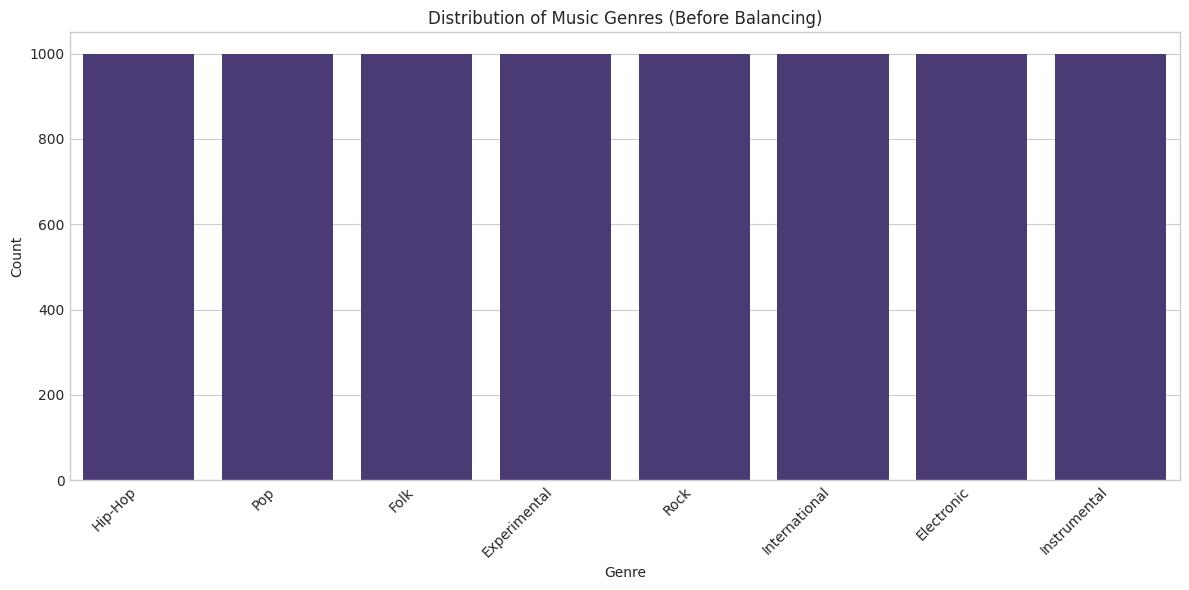

In [8]:
# --- 1. Load Metadata ---
tracks_with_genres = load_metadata(METADATA_PATH, FMA_PATH)

if tracks_with_genres:
    print(f"\nFound {len(tracks_with_genres)} tracks with valid genres and existing audio files.")
    genre_counts = pd.Series(list(tracks_with_genres.values())).value_counts()
    print("\nInitial Genre distribution:")
    print(genre_counts)

    # --- Initial Data Visualization ---
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_counts.index, y=genre_counts.values)
    plt.title('Distribution of Music Genres (Before Balancing)')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nExiting: Metadata loading failed or no valid tracks found.")
    # In a notebook, we might not exit but rather stop execution here.
    assert tracks_with_genres is not None, "Metadata loading failed."

## Step 2: Balance Dataset (Optional)
Limit the number of samples per genre to create a more balanced dataset if `MAX_SAMPLES_PER_GENRE` is set.


Balancing dataset to max 1000 samples per genre...
Total tracks after balancing: 8000

Balanced Genre distribution:
Electronic       1000
Experimental     1000
Folk             1000
Hip-Hop          1000
Instrumental     1000
International    1000
Pop              1000
Rock             1000
Name: count, dtype: int64


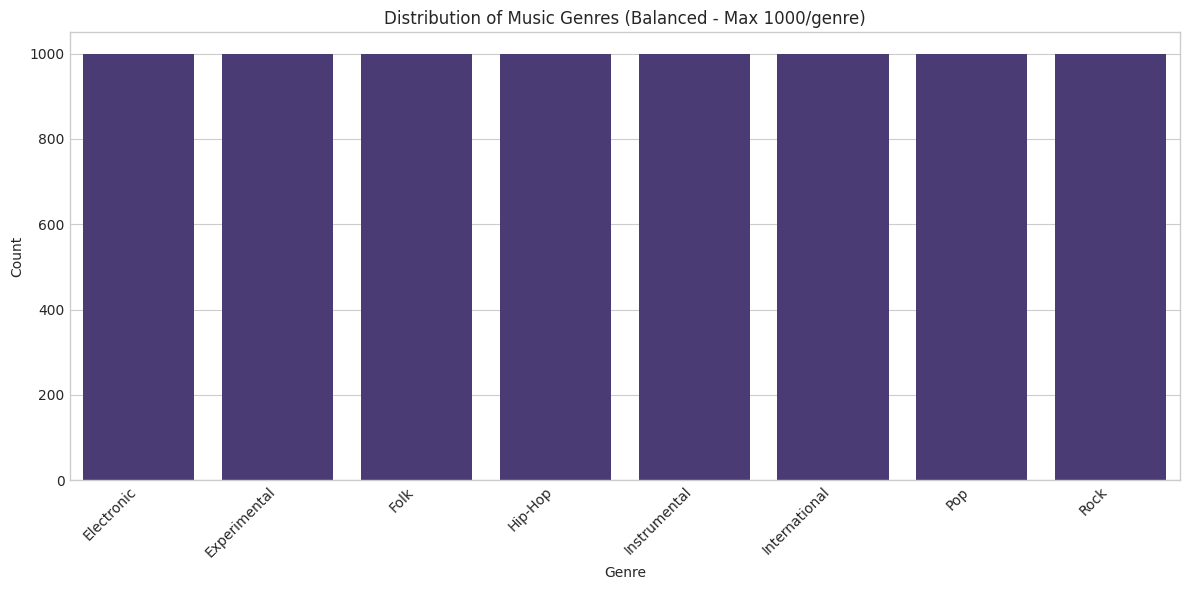

In [9]:
# --- 2. Balance Dataset (Optional) ---
all_paths = list(tracks_with_genres.keys())
all_genres = list(tracks_with_genres.values())
balanced_paths = []
balanced_genres = []

if MAX_SAMPLES_PER_GENRE is not None and MAX_SAMPLES_PER_GENRE > 0:
    print(f"\nBalancing dataset to max {MAX_SAMPLES_PER_GENRE} samples per genre...")
    tracks_by_genre = {}
    for path, genre in tracks_with_genres.items():
        if genre not in tracks_by_genre: tracks_by_genre[genre] = []
        tracks_by_genre[genre].append(path)

    unique_genres = sorted(tracks_by_genre.keys())
    for genre in unique_genres:
        paths = tracks_by_genre[genre]
        np.random.shuffle(paths) # Shuffle before slicing
        track_subset = paths[:MAX_SAMPLES_PER_GENRE]
        balanced_paths.extend(track_subset)
        balanced_genres.extend([genre] * len(track_subset))

    print(f"Total tracks after balancing: {len(balanced_paths)}")
    genre_counts_balanced = pd.Series(balanced_genres).value_counts()
    print("\nBalanced Genre distribution:")
    print(genre_counts_balanced)

    # Visualize balanced distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_counts_balanced.index, y=genre_counts_balanced.values)
    plt.title(f'Distribution of Music Genres (Balanced - Max {MAX_SAMPLES_PER_GENRE}/genre)')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping dataset balancing or MAX_SAMPLES_PER_GENRE is not set.")
    balanced_paths = all_paths
    balanced_genres = all_genres
    # Use original counts if not balanced
    genre_counts_balanced = pd.Series(balanced_genres).value_counts()

## Step 3: Visualize Spectrogram Examples
Display Mel spectrograms for a few random samples from each genre in the (potentially balanced) dataset.


Visualizing some mel spectrogram examples...


Visualizing Genres:   0%|          | 0/8 [00:00<?, ?it/s]

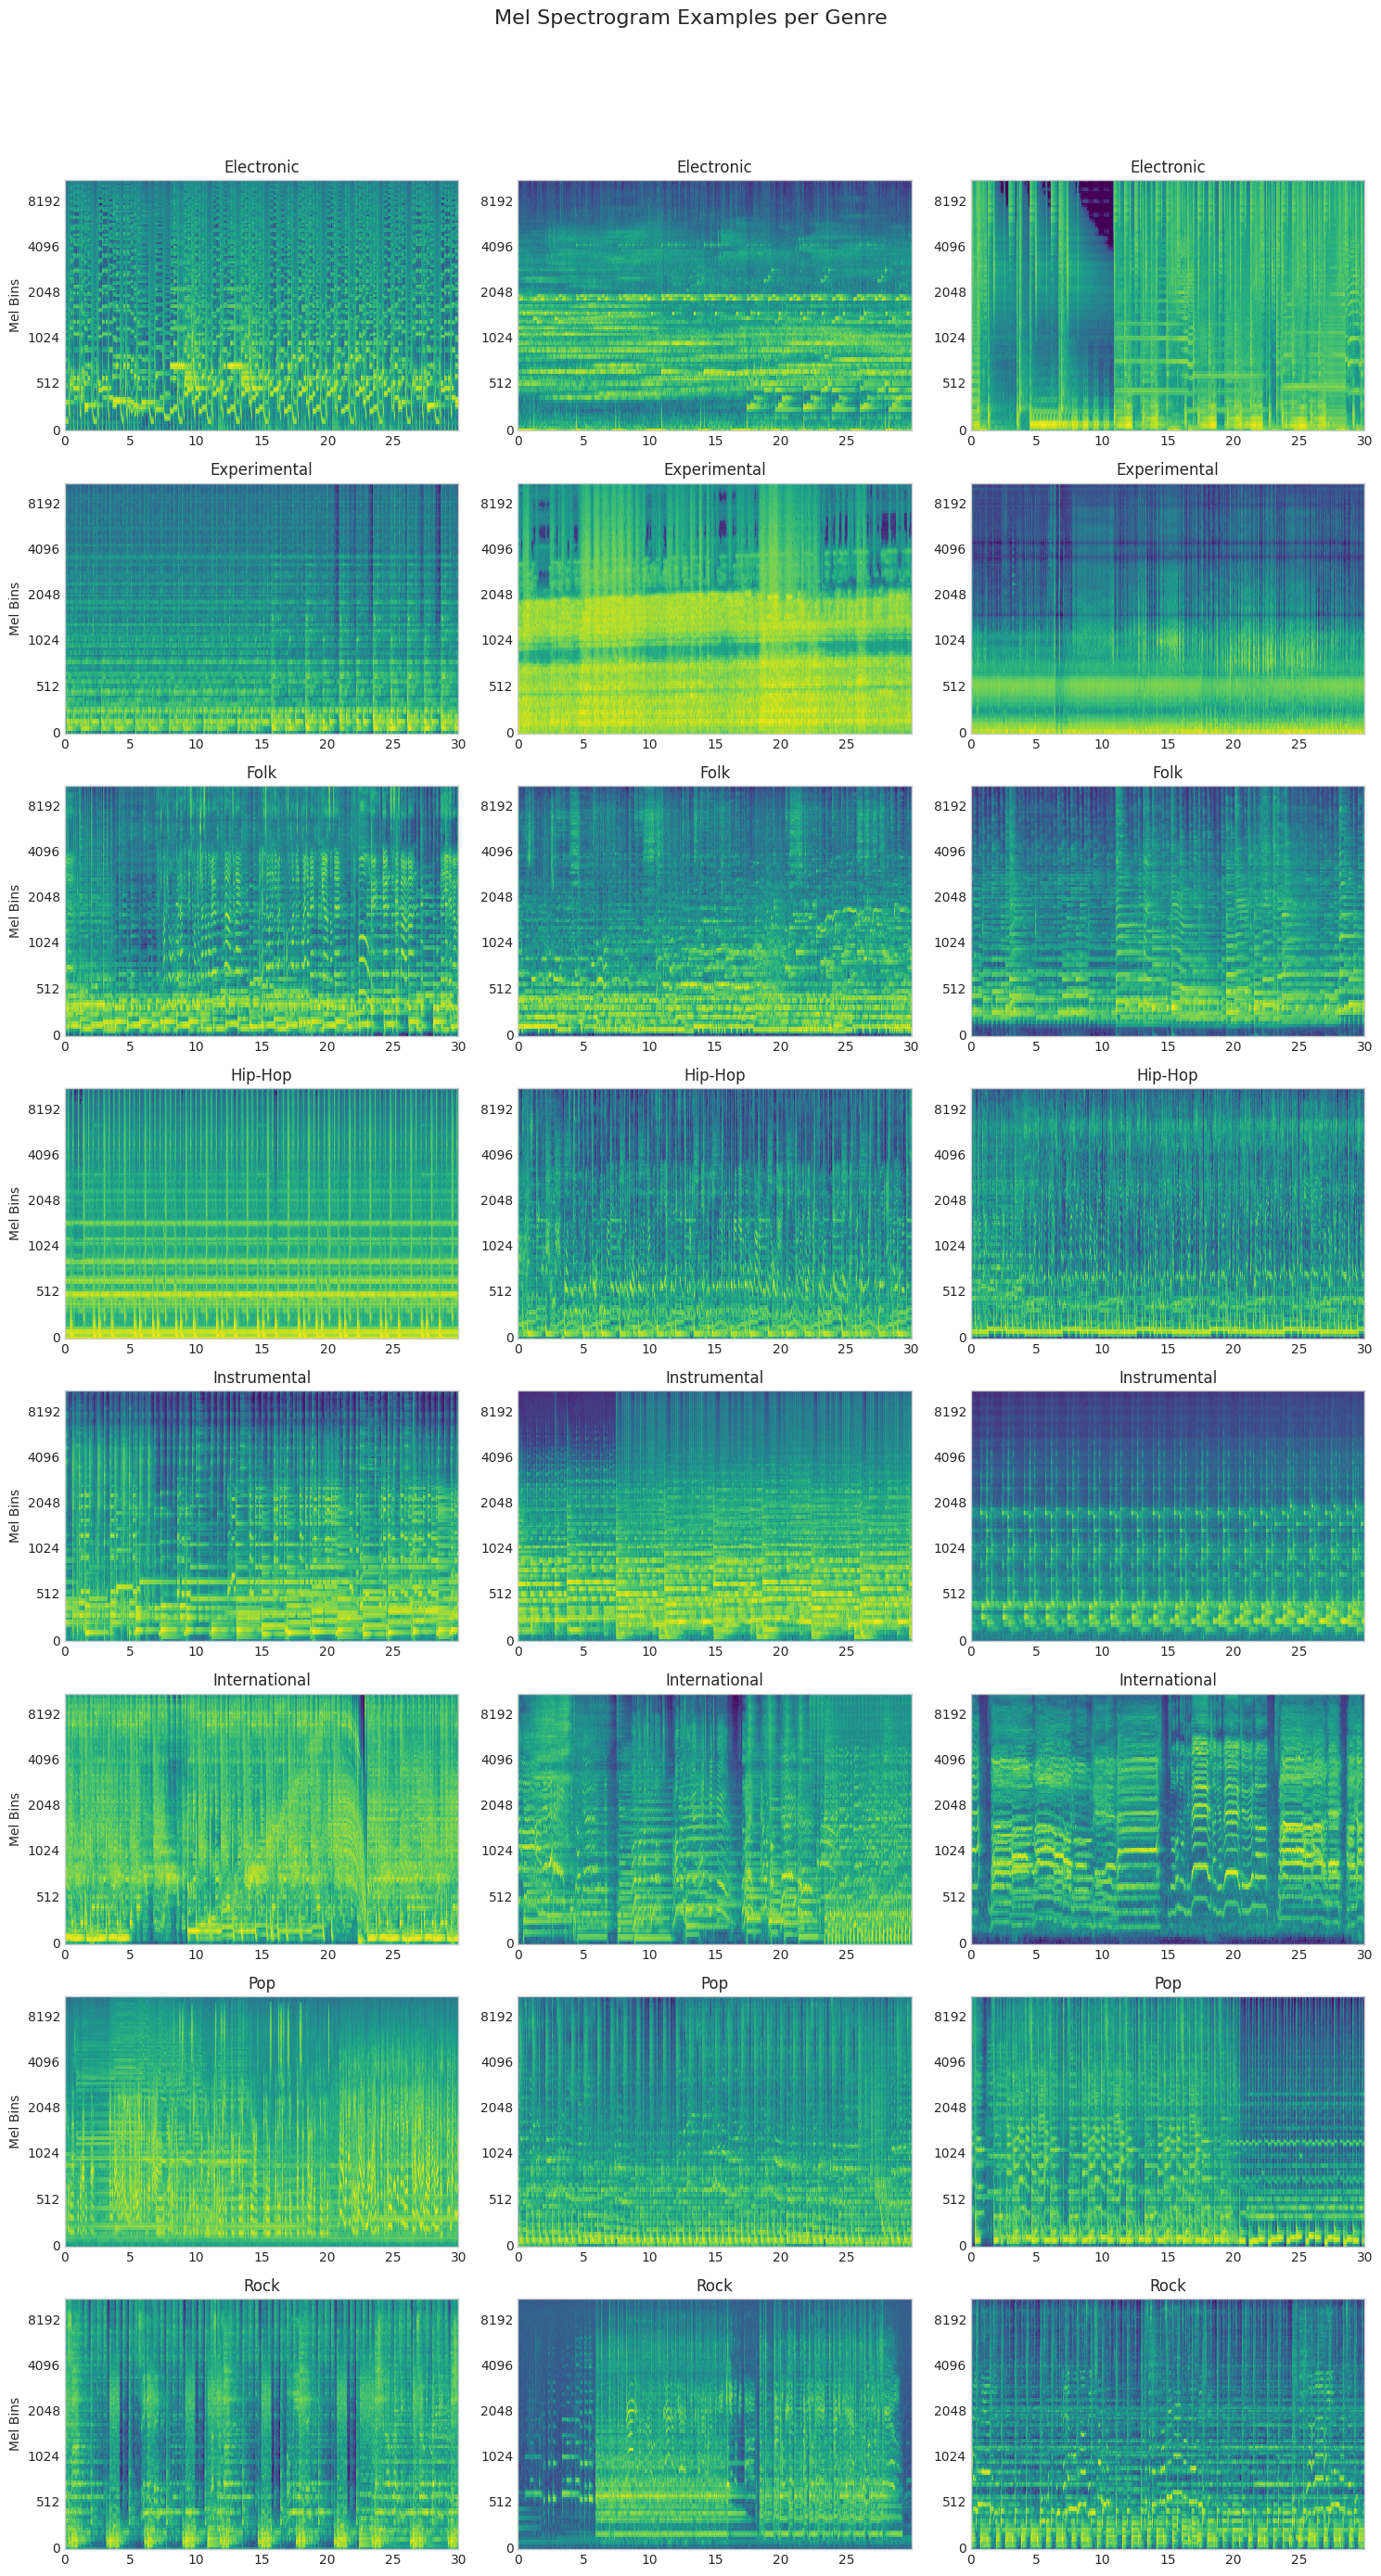

In [10]:
# --- 3. Visualize Spectrogram Examples ---
print("\nVisualizing some mel spectrogram examples...")
visualize_examples(balanced_paths, balanced_genres, num_examples_per_genre=3)

## Step 4: Feature Extraction
Extract MFCC features from the selected audio files using `torchaudio`. This can take a significant amount of time depending on the dataset size and hardware.

In [11]:
# --- 4. Feature Extraction ---
feature_start_time = time.time()
print(f"\nExtracting MFCC features using torchaudio...")
X_features = []
y_labels = []
processed_files_count = 0

# Apply overall file limit if set
paths_to_process = balanced_paths
genres_to_process = balanced_genres
if MAX_FILES_TO_PROCESS is not None and MAX_FILES_TO_PROCESS > 0:
    print(f"Limiting feature extraction to {MAX_FILES_TO_PROCESS} files.")
    # Shuffle before slicing to get a random subset if limited
    indices = np.arange(len(balanced_paths))
    np.random.shuffle(indices)
    paths_to_process = [balanced_paths[i] for i in indices[:MAX_FILES_TO_PROCESS]]
    genres_to_process = [balanced_genres[i] for i in indices[:MAX_FILES_TO_PROCESS]]


print(f"Processing {len(paths_to_process)} audio files...")
for track_path, genre in tqdm(zip(paths_to_process, genres_to_process), total=len(paths_to_process), desc="Extracting Features"):
    features = extract_features_torchaudio(track_path, fixed_length=FIXED_LENGTH)
    if features is not None:
        X_features.append(features)
        y_labels.append(genre)
        processed_files_count += 1

feature_end_time = time.time()
print(f"\nFeature extraction completed in {feature_end_time - feature_start_time:.2f} seconds.")

if not X_features:
    raise ValueError("No features were successfully extracted. Check audio files, paths, permissions, and torchaudio setup.")
else:
    print(f"Successfully extracted features from {processed_files_count} out of {len(paths_to_process)} files.")

# Convert lists to numpy arrays
# Shape X: (n_samples, n_mfcc, fixed_length) -> e.g. (7997, 40, 128) before adding channel dim
X = np.array(X_features)
y = np.array(y_labels)

print(f"Feature matrix shape (X) before channel dim: {X.shape}")
print(f"Label array shape (y): {y.shape}")


Extracting MFCC features using torchaudio...
Processing 8000 audio files...


Extracting Features:   0%|          | 0/8000 [00:00<?, ?it/s]

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...



Feature extraction completed in 790.75 seconds.
Successfully extracted features from 7994 out of 8000 files.
Feature matrix shape (X) before channel dim: (7994, 40, 128)
Label array shape (y): (7994,)


## Step 5: Data Preparation for PyTorch
Encode labels, split data into training, validation, and test sets, and create PyTorch `Dataset` and `DataLoader` objects.

In [12]:
# --- 5. Data Preparation for PyTorch ---
print("\nPreparing data for PyTorch...")

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Genre classes ({num_classes}): {label_encoder.classes_}")

# Split data: First into Train+Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SPLIT_SIZE,
    random_state=SEED,
    stratify=y_encoded # Important for imbalanced datasets
)

# Split Train+Validation into Train and Validation
# Adjust validation size relative to the remaining data
relative_val_size = VALIDATION_SPLIT_SIZE / (1 - TEST_SPLIT_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=relative_val_size,
    random_state=SEED,
    stratify=y_train_val # Stratify this split as well
)

print(f"\nData Split:")
print(f"  Training set size:   {len(X_train)}")
print(f"  Validation set size: {len(X_val)}")
print(f"  Test set size:       {len(X_test)}")

# Create PyTorch Datasets
# Note: The channel dimension (1) is added inside the AudioDataset class now
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Determine number of workers based on CPU cores for potentially faster loading
num_workers = min(os.cpu_count(), 4) if os.cpu_count() else 0 # Use up to 4 workers or 0 if cpu_count fails
print(f"Using {num_workers} workers for DataLoaders.")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if device == 'cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if device == 'cuda' else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if device == 'cuda' else False)

print("\nDatasets and DataLoaders created.")


Preparing data for PyTorch...
Genre classes (8): ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']

Data Split:
  Training set size:   4796
  Validation set size: 1599
  Test set size:       1599
Using 4 workers for DataLoaders.

Datasets and DataLoaders created.


## Step 6: Initialize Model, Loss, Optimizer
Define the model instance, loss function (Cross Entropy for classification), optimizer (Adam), and a learning rate scheduler.

In [13]:
# --- 6. Initialize Model, Loss, Optimizer ---
print("\nInitializing Model, Loss Function, and Optimizer...")

# Input shape for the model: (channels, height, width) = (1, n_mfcc, fixed_length)
# Example: (1, 40, 128) based on current settings
input_shape_model = (1, N_MFCC, FIXED_LENGTH)
model = GenreClassifier(input_shape=input_shape_model, num_classes=num_classes).to(device)

print("\nModel Architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Learning rate scheduler: Reduces LR if validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


Initializing Model, Loss Function, and Optimizer...

Model Architecture:
GenreClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in

/home/pac/anaconda3/envs/AudioEmotion/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Step 7: Training Loop
Train the model for `NUM_EPOCHS`, performing validation after each epoch. Implement early stopping based on validation loss and save the best performing model.

In [14]:
# --- 7. Training Loop ---
print("\nStarting Training...")
training_start_time = time.time()

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device) # Discard preds/targets from validation

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Summary (Duration: {epoch_duration:.2f}s):")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc:.4f}")

    # Update learning rate scheduler based on validation loss
    scheduler.step(val_loss)

    # Early stopping and saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model state dictionary
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  Validation loss decreased to {val_loss:.4f}. Saving best model to '{MODEL_SAVE_PATH}'")
    else:
        epochs_no_improve += 1
        print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best was {best_val_loss:.4f}")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

training_end_time = time.time()
print(f"\nTraining finished in {training_end_time - training_start_time:.2f} seconds!")


Starting Training...

--- Epoch 1/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Summary (Duration: 22.97s):
  Train Loss: 1.8270 | Train Acc: 0.3271
  Valid Loss: 1.8327 | Valid Acc: 0.3333
  Validation loss decreased to 1.8327. Saving best model to 'best_genre_classifier.pth'

--- Epoch 2/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 Summary (Duration: 20.18s):
  Train Loss: 1.6500 | Train Acc: 0.4005
  Valid Loss: 1.8953 | Valid Acc: 0.3365
  Validation loss did not improve for 1 epoch(s). Best was 1.8327

--- Epoch 3/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 Summary (Duration: 17.57s):
  Train Loss: 1.5498 | Train Acc: 0.4402
  Valid Loss: 1.6214 | Valid Acc: 0.4353
  Validation loss decreased to 1.6214. Saving best model to 'best_genre_classifier.pth'

--- Epoch 4/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 Summary (Duration: 25.21s):
  Train Loss: 1.4888 | Train Acc: 0.4637
  Valid Loss: 1.6283 | Valid Acc: 0.4371
  Validation loss did not improve for 1 epoch(s). Best was 1.6214

--- Epoch 5/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 Summary (Duration: 17.28s):
  Train Loss: 1.4248 | Train Acc: 0.4933
  Valid Loss: 1.6080 | Valid Acc: 0.4415
  Validation loss decreased to 1.6080. Saving best model to 'best_genre_classifier.pth'

--- Epoch 6/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 Summary (Duration: 18.18s):
  Train Loss: 1.3706 | Train Acc: 0.5198
  Valid Loss: 1.6626 | Valid Acc: 0.4253
  Validation loss did not improve for 1 epoch(s). Best was 1.6080

--- Epoch 7/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 Summary (Duration: 166.11s):
  Train Loss: 1.2900 | Train Acc: 0.5427
  Valid Loss: 1.6136 | Valid Acc: 0.4597
  Validation loss did not improve for 2 epoch(s). Best was 1.6080

--- Epoch 8/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 Summary (Duration: 21.55s):
  Train Loss: 1.2160 | Train Acc: 0.5655
  Valid Loss: 1.6335 | Valid Acc: 0.4422
  Validation loss did not improve for 3 epoch(s). Best was 1.6080

--- Epoch 9/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 Summary (Duration: 20.94s):
  Train Loss: 1.1236 | Train Acc: 0.6053
  Valid Loss: 1.6349 | Valid Acc: 0.4559
  Validation loss did not improve for 4 epoch(s). Best was 1.6080

--- Epoch 10/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 Summary (Duration: 19.02s):
  Train Loss: 1.0679 | Train Acc: 0.6134
  Valid Loss: 1.6535 | Valid Acc: 0.4403
  Validation loss did not improve for 5 epoch(s). Best was 1.6080

--- Epoch 11/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11 Summary (Duration: 27.19s):
  Train Loss: 0.9681 | Train Acc: 0.6637
  Valid Loss: 1.6628 | Valid Acc: 0.4584
  Validation loss did not improve for 6 epoch(s). Best was 1.6080

--- Epoch 12/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12 Summary (Duration: 11995.56s):
  Train Loss: 0.8118 | Train Acc: 0.7133
  Valid Loss: 1.6416 | Valid Acc: 0.4615
  Validation loss did not improve for 7 epoch(s). Best was 1.6080

--- Epoch 13/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13 Summary (Duration: 15.60s):
  Train Loss: 0.7395 | Train Acc: 0.7473
  Valid Loss: 1.7266 | Valid Acc: 0.4509
  Validation loss did not improve for 8 epoch(s). Best was 1.6080

--- Epoch 14/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14 Summary (Duration: 14.66s):
  Train Loss: 0.6873 | Train Acc: 0.7611
  Valid Loss: 1.6969 | Valid Acc: 0.4684
  Validation loss did not improve for 9 epoch(s). Best was 1.6080

--- Epoch 15/50 ---


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15 Summary (Duration: 11.56s):
  Train Loss: 0.6372 | Train Acc: 0.7807
  Valid Loss: 1.7291 | Valid Acc: 0.4622
  Validation loss did not improve for 10 epoch(s). Best was 1.6080

Early stopping triggered after 15 epochs.

Training finished in 12413.79 seconds!


## Step 8: Plot Training History
Visualize the training and validation accuracy and loss over epochs.


Plotting training history...


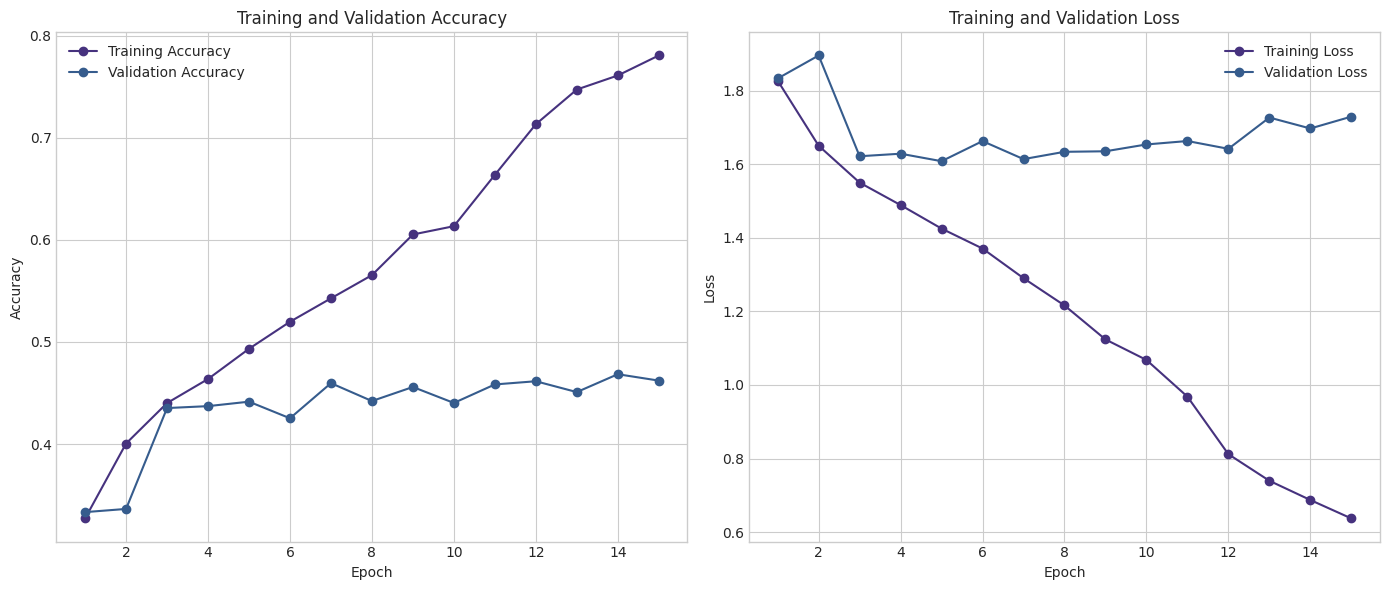

In [15]:
# --- 8. Plot Training History ---
print("\nPlotting training history...")
plot_training_history(history)

## Step 9: Evaluate on Test Set
Load the best saved model weights and evaluate its performance on the unseen test set.

In [16]:
# --- 9. Evaluate on Test Set ---
print("\nEvaluating on Test Set using the best model...")

# Load the best model weights saved during training
try:
    # Instantiate a new model or use the existing one
    eval_model = GenreClassifier(input_shape=input_shape_model, num_classes=num_classes).to(device)
    eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    eval_model.eval() # Set to evaluation mode
    print(f"Loaded best model weights from '{MODEL_SAVE_PATH}'")
except FileNotFoundError:
    print(f"Warning: Best model file '{MODEL_SAVE_PATH}' not found. Evaluating with the model from the last epoch.")
    # Use the model currently in memory (last epoch state)
    eval_model = model
    eval_model.eval()
except Exception as e:
     print(f"Error loading model weights: {e}. Evaluating with the model from the last epoch.")
     eval_model = model
     eval_model.eval()


# Evaluate using the validate function
test_loss, test_acc, test_preds, test_targets = validate(eval_model, test_loader, criterion, device)

print(f"\nTest Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")


Evaluating on Test Set using the best model...
Loaded best model weights from 'best_genre_classifier.pth'


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Test Set Performance:
  Test Loss: 1.6149
  Test Accuracy: 0.4328


## Step 10: Detailed Evaluation
Generate a classification report (precision, recall, F1-score) and a confusion matrix for the test set predictions.


Generating detailed evaluation metrics for the Test Set...

Classification Report (Test Set):
               precision    recall  f1-score   support

   Electronic      0.561     0.300     0.391       200
 Experimental      0.294     0.515     0.375       200
         Folk      0.502     0.545     0.523       200
      Hip-Hop      0.582     0.412     0.482       199
 Instrumental      0.413     0.525     0.463       200
International      0.527     0.435     0.477       200
          Pop      0.282     0.175     0.216       200
         Rock      0.461     0.555     0.503       200

     accuracy                          0.433      1599
    macro avg      0.453     0.433     0.429      1599
 weighted avg      0.453     0.433     0.429      1599


Plotting Confusion Matrix (Test Set)...


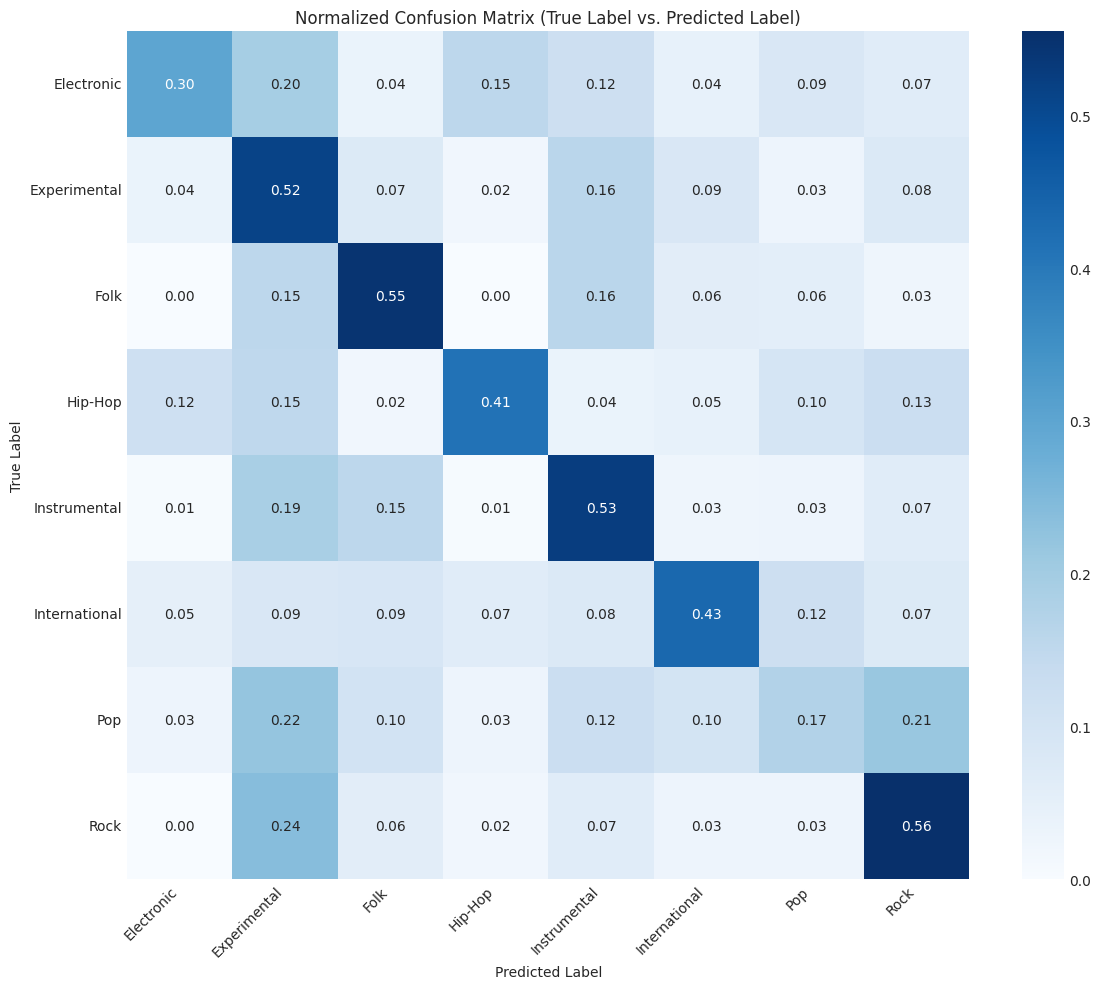

In [17]:
# --- 10. Detailed Evaluation (Classification Report & Confusion Matrix) ---
print("\nGenerating detailed evaluation metrics for the Test Set...")

# Ensure we have predictions and targets from the test evaluation step
if 'test_preds' in locals() and 'test_targets' in locals():
    print("\nClassification Report (Test Set):")
    # Use integer labels for report, map to names for display
    print(classification_report(test_targets, test_preds, target_names=label_encoder.classes_, digits=3))

    print("\nPlotting Confusion Matrix (Test Set)...")
    plot_confusion_matrix(test_targets, test_preds, classes=label_encoder.classes_)
else:
    print("Could not generate detailed report: Test predictions not available.")

## Step 11: Example Prediction
Select a random audio file (from the original balanced list for simplicity) and predict its genre using the trained model. Visualize the waveform and spectrogram alongside the prediction.


Predicting genres for files in manual_test folder...
Found 4 audio file(s) to process

Processing: Mille Ponts.mp3
Prediction Result:
  Predicted Genre: Experimental
  Confidence: 0.4477


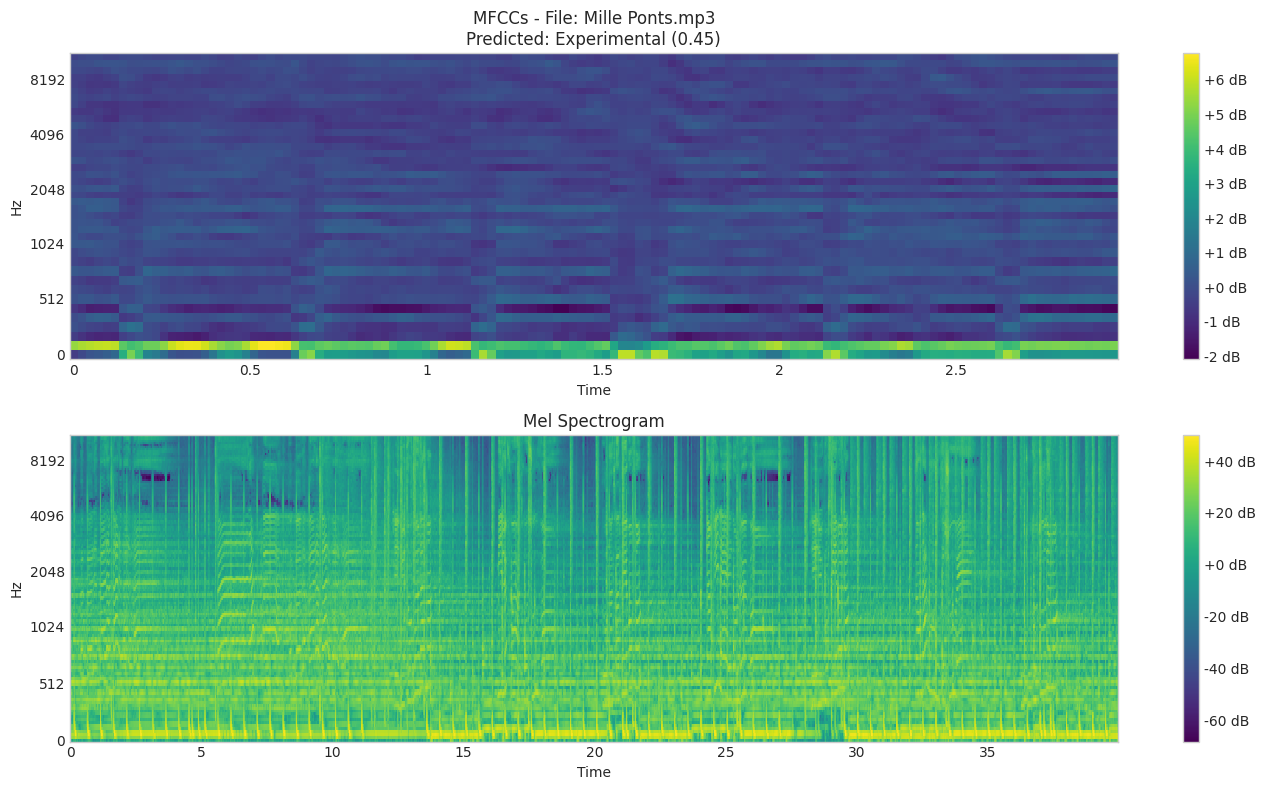

--------------------------------------------------

Processing: AC⧸DC - Thunderstruck (Official Video).mp3
Prediction Result:
  Predicted Genre: Rock
  Confidence: 0.7557


/tmp/ipykernel_5154/2940399613.py:66: UserWarning: Glyph 10744 (\N{BIG SOLIDUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/pac/anaconda3/envs/AudioEmotion/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10744 (\N{BIG SOLIDUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


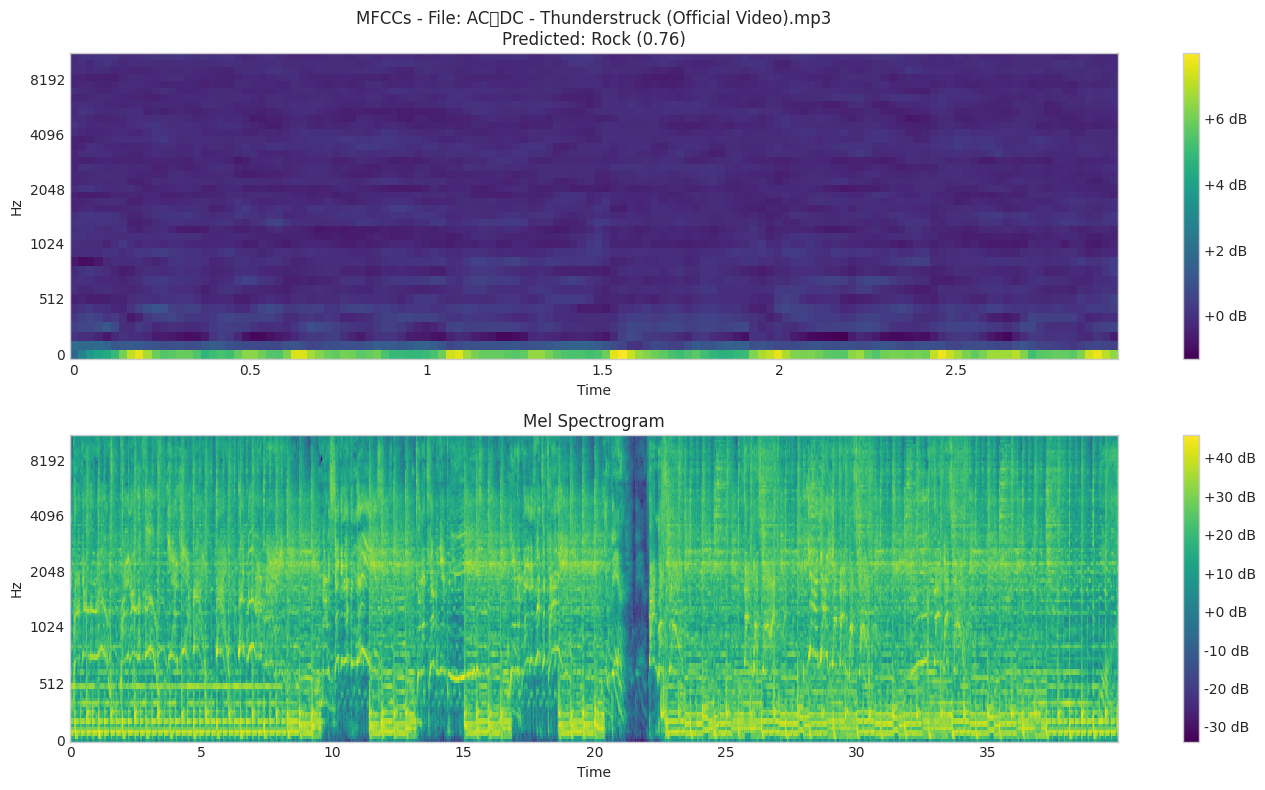

--------------------------------------------------

Processing: Soldier, Poet, King.mp3
Prediction Result:
  Predicted Genre: Folk
  Confidence: 0.5492


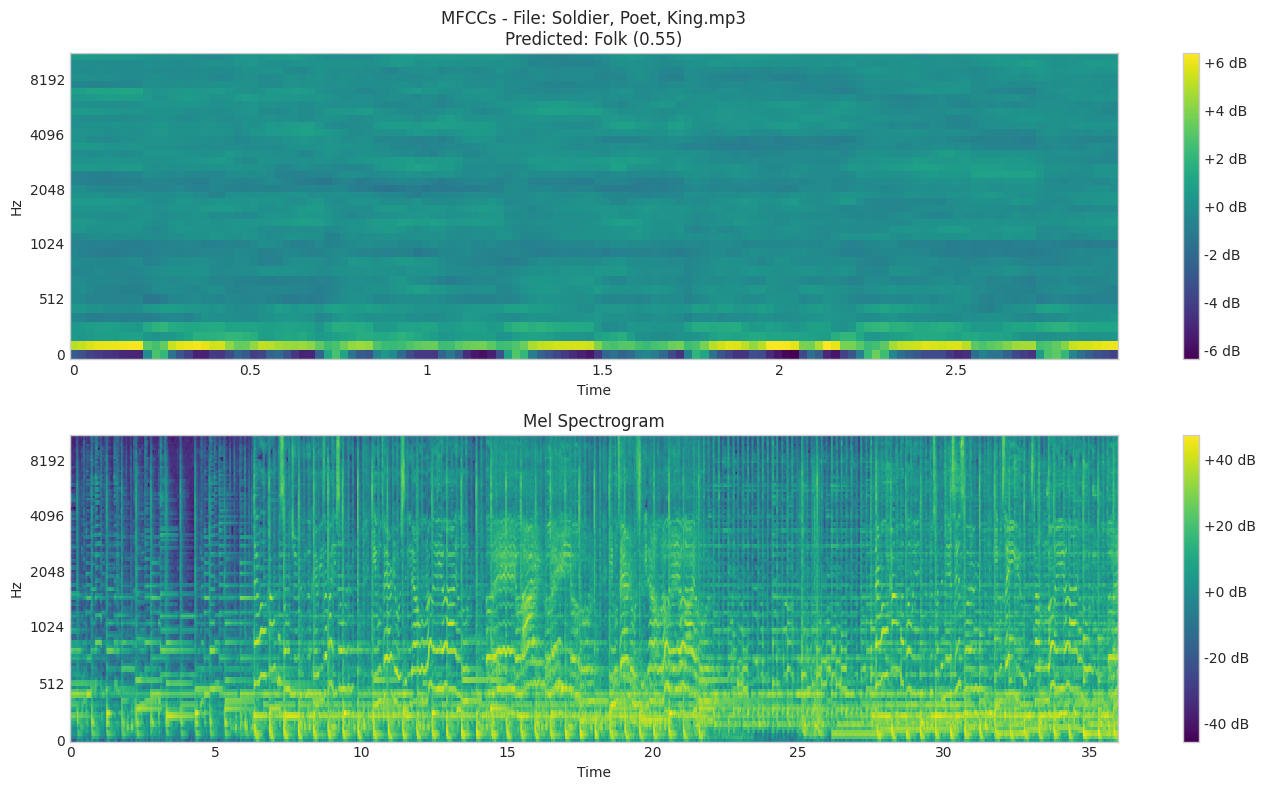

--------------------------------------------------

Processing: The Notorious B.I.G. - Big Poppa (Official Music Video) [HD].mp3
Prediction Result:
  Predicted Genre: Hip-Hop
  Confidence: 0.7699


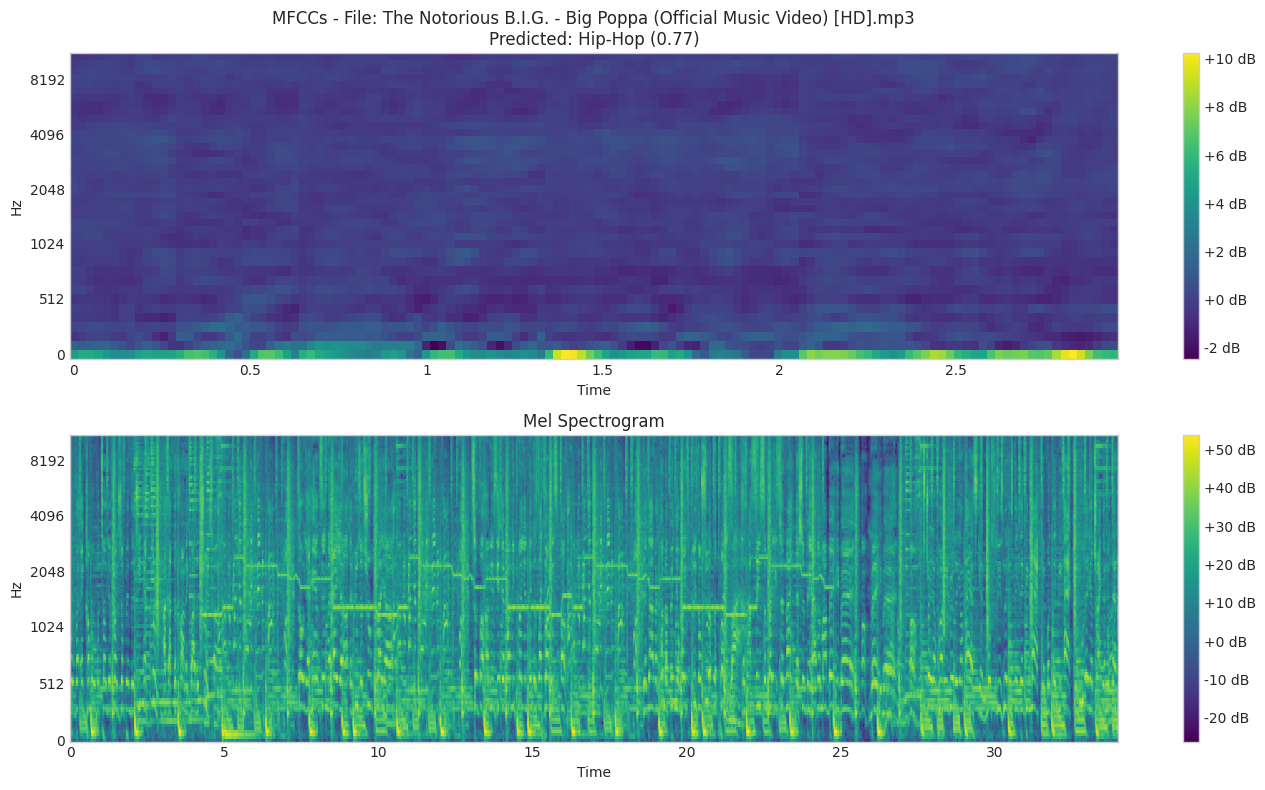

--------------------------------------------------


In [23]:
# --- 11. Example Prediction on Test Files ---
print("\nPredicting genres for files in manual_test folder...")

# Use the evaluated model (best loaded one if possible)
prediction_model = eval_model

# Define the manual test folder path
manual_test_path = "manual_test"

if os.path.exists(manual_test_path):
    # Get all audio files in the folder
    audio_files = [f for f in os.listdir(manual_test_path) if f.endswith(('.mp3', '.wav'))]
    
    if not audio_files:
        print(f"No audio files found in {manual_test_path}")
    else:
        print(f"Found {len(audio_files)} audio file(s) to process")
        
        for audio_file in audio_files:
            file_path = os.path.join(manual_test_path, audio_file)
            print(f"\nProcessing: {audio_file}")
            
            # Predict
            predicted_genre, confidence, features = predict_genre(file_path, prediction_model, label_encoder, device)
            
            print(f"Prediction Result:")
            print(f"  Predicted Genre: {predicted_genre}")
            print(f"  Confidence: {confidence:.4f}")
            
            # Visualize the audio and its spectrogram
            if features is not None:  # Check if feature extraction succeeded
                try:
                    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
                    
                    # Plot MFCCs used for prediction
                    img1 = librosa.display.specshow(
                        features,
                        sr=SR,
                        hop_length=HOP_LENGTH,
                        x_axis='time',
                        y_axis='mel',
                        ax=axes[0],
                        cmap='viridis'
                    )
                    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
                    axes[0].set_title(f"MFCCs - File: {audio_file}\nPredicted: {predicted_genre} ({confidence:.2f})")
                    
                    # Plot Mel Spectrogram
                    mel_spec_db = generate_melspectrogram(file_path)
                    if mel_spec_db is not None:
                        img2 = librosa.display.specshow(
                            mel_spec_db,
                            sr=SR,
                            hop_length=HOP_LENGTH,
                            x_axis='time',
                            y_axis='mel',
                            ax=axes[1],
                            cmap='viridis'
                        )
                        fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
                        axes[1].set_title("Mel Spectrogram")
                    else:
                        axes[1].set_title("Mel Spectrogram (Error Generating)")
                        axes[1].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                except Exception as e:
                    print(f"Error visualizing prediction: {e}")
            else:
                print("Skipping visualization as feature extraction failed.")
            
            print("-" * 50)  # Separator between files
else:
    print(f"Error: {manual_test_path} directory not found.")
    print(f"Please create a '{manual_test_path}' directory and add your test audio files (.mp3 or .wav).")

---
## End of Notebook
---